# <i> Retraining models to predict age in new datasets with missing genes</i>
<b> This notebook uses the same training data as other models, but retrains a new model based on the genes present in your new dataset where you want age predictions. We will use 3 additional fetal brain datasets to test this: \
Wang et al., 2024 human brain dataset; Cao et al. 2020 human fetal cell atlas; Walchii et al., 2024 human fetal brain vasculature dataset 
>Data were downloaded from the following links
>1) https://cellxgene.cziscience.com/collections/c95ca269-68a7-47c5-82db-da227f31b598 
>2) https://cellxgene.cziscience.com/collections/c114c20f-1ef4-49a5-9c2e-d965787fb90c/private 
>3) https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE256493&format=file&file=GSE256493%5FFetal%5FCNS%5Funsorted%5Fendothelial%5Fand%5Fperivascular%5Fcells%5Fseurat%5Fobject%2Erds%2Egz
Create a data/ folder in the working directory and download the seurat objects from above links

In [1]:
library(caret)
library(Seurat)
library(ggplot2)
library(ggpubr)
library(tidyr)
library(stringr)
library(readr)

Loading required package: ggplot2

Loading required package: lattice

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




In [2]:
setwd("/home/sridevi/inkwell03_sridevi/metadevorganoid/werneranalysis/DevTime_gitub_repo/") #change to the working directory

In [3]:
final_common_genes<-readRDS("models/commongenes.rds")#list of common genes used in original model training

In [4]:
#check model coefficients
celltypeagnosticmodel<-readRDS("models/original_celltypeagnostic_model.rds") #load original cell type agnostic model
coefs<-as.data.frame(coef(celltypeagnosticmodel$finalModel, celltypeagnosticmodel$finalModel$lambdaOpt))%>%dplyr::filter(s1!=0)
coefs$genes<-rownames(coefs)
coefs

,s1,genes
,<dbl>,<chr>
(Intercept),11.25612595,(Intercept)
PDK4,0.40616305,PDK4
TAC1,-0.06138818,TAC1
CX3CL1,2.02815101,CX3CL1
PNPLA4,-0.96997077,PNPLA4
CACNA2D2,-1.85735642,CACNA2D2
CAMK1G,0.44071996,CAMK1G
NFIX,0.15785721,NFIX
CD9,0.06357692,CD9


In [5]:
#convert ENSG to gene symbol
library(biomaRt)
library(org.Hs.eg.db)
mart <- useEnsembl("ensembl","hsapiens_gene_ensembl")
symb <- keys(org.Hs.eg.db, "SYMBOL")
z <- getBM(c("ensembl_gene_id","hgnc_symbol"), "hgnc_symbol", symb, mart)#get all human gene symbols and names mapped


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname

## <b>Load all new fetal brain datasets, aggregate expression and look for common genes
### 1. Wang 2024 

In [6]:
Wang2024_fetaldata=readRDS("data/Wang2024_humanfetal.rds")#load Wang et al. dataset
mapped_genes<-z[z$ensembl_gene_id %in% Features(Wang2024_fetaldata),]

pb_Wang2024<-AggregateExpression(Wang2024_fetaldata,group.by = c("Sample_ID","cell_type"),return.seurat = TRUE)
pb_Wang2024_metadata<-Wang2024_fetaldata@meta.data%>%group_by(Sample_ID,cell_type)%>%
dplyr::select(Sample_ID,cell_type,Estimated_postconceptional_age_in_days,Region,Class,development_stage,Group)%>%
unique

pb_Wang2024_predict<-pb_Wang2024@assays$RNA$data[mapped_genes$ensembl_gene_id,] #keep log-normalized gene exp
rownames(pb_Wang2024_predict)<-mapped_genes$hgnc_symbol


Centering and scaling data matrix



In [8]:
dim(pb_Wang2024_predict)
rm(Wang2024_fetaldata)

[1] 25217  1047

### 2a. Cao 2020: telencephalon 

In [9]:
Cao2020_humanfetal<-readRDS("data/Cao2020_humanfetal.rds")
Cao_brain<-subset(Cao2020_humanfetal,subset=tissue%in%c("telencephalon"))
pb_Cao2020<-AggregateExpression(Cao_brain,slot="counts",group.by = c("donor_id","cell_type"),return.seurat = TRUE)

pb_Cao2020_metadata<-Cao_brain@meta.data%>%group_by(donor_id,cell_type)%>%dplyr::select(disease,Development_day)%>%unique%>%as.data.frame

mapped_genes_cao<-z[z$ensembl_gene_id %in% Features(pb_Cao2020),]
pb_Cao2020_predict<-pb_Cao2020@assays$RNA$data[mapped_genes_cao$ensembl_gene_id,]
rownames(pb_Cao2020_predict)<-mapped_genes_cao$hgnc_symbol


Centering and scaling data matrix

Adding missing grouping variables: `donor_id`, `cell_type`


In [10]:
dim(pb_Cao2020_predict)

[1] 34676    60

### 2b. Cao 2020: cerebellum

In [11]:
#Cao 2020 cerebellum
Cao_cerebellum<-subset(Cao2020_humanfetal,subset=tissue%in%c("cerebellum"))

pb_Cao2020_cerebellum<-AggregateExpression(Cao_cerebellum,slot="counts",group.by = c("donor_id","cell_type"),return.seurat = TRUE)

pb_Cao2020_cerebellum_metadata<-Cao_cerebellum@meta.data%>%group_by(donor_id,cell_type)%>%dplyr::select(disease,Development_day)%>%unique%>%as.data.frame

pb_Cao2020_cerebellum_predict<-pb_Cao2020_cerebellum@assays$RNA$data[mapped_genes_cao$ensembl_gene_id,]
rownames(pb_Cao2020_cerebellum_predict)<-mapped_genes_cao$hgnc_symbol

rm(Cao2020_humanfetal,Cao_brain)

Centering and scaling data matrix

Adding missing grouping variables: `donor_id`, `cell_type`


In [12]:
dim(pb_Cao2020_cerebellum_predict)

[1] 34676    65

### 3. Walchii 2024 fetal brain vasculature 

In [13]:
Fetal_CNS_unsorted_endothelial_and_perivascular_cells_seurat_object<-readRDS("data/fetal human vasculature2024/Fetal_CNS_unsorted_endothelial_and_perivascular_cells_seurat_object.rds")
pb_vasc_unsorted<-AggregateExpression(Fetal_CNS_unsorted_endothelial_and_perivascular_cells_seurat_object,slot="counts",group.by = c("Patient","Cellclusters"),return.seurat = TRUE)
vasc_unsorted_metadata<-Fetal_CNS_unsorted_endothelial_and_perivascular_cells_seurat_object@meta.data%>%group_by(Patient,Cellclusters)%>%dplyr::select(age)%>%unique%>%as.data.frame

pb_vasc_unsorted_predict<-pb_vasc_unsorted@assays$RNA$data[intersect(final_common_genes,Features(Fetal_CNS_unsorted_endothelial_and_perivascular_cells_seurat_object)),]
rm(Fetal_CNS_unsorted_endothelial_and_perivascular_cells_seurat_object)


Warning message:
“The counts layer for the integrated assay is empty. Skipping assay.”
Centering and scaling data matrix

Adding missing grouping variables: `Patient`, `Cellclusters`


In [14]:
dim(pb_vasc_unsorted_predict)

[1] 10894    47

In [15]:
length(final_common_genes)#check that all genes are present in the dataset
#check the intersection of new genes in old model genes
length(intersect(rownames(pb_Wang2024_predict),final_common_genes))

length(intersect(rownames(pb_Cao2020_predict),final_common_genes))

length(intersect(rownames(pb_vasc_unsorted_predict),final_common_genes))



[1] 10957

[1] 10949

[1] 10560

[1] 10894

#### <b> Since a few genes are missing in each of the datasets, we'll retrain a model with the new shared gene list

In [16]:
newsharedgenes<-Reduce(intersect,list(final_common_genes,rownames(pb_Wang2024_predict),
                                     rownames(pb_Cao2020_predict),
                                     rownames(pb_vasc_unsorted_predict)))
length(newsharedgenes) 

[1] 10499

---

## Model training using previous training data: cell type aggregated transcriptomes from 11 studies

In [18]:
getwd()

[1] "/inkwell03/sridevi/metadevorganoid/werneranalysis/DevTime_gitub_repo"

In [19]:
#LOAD TRAINING DATA FROM PREVIOUS FETAL DATASETS (THIS DOES NOT INCLUDE THE CURRENT DATASET)
load("models/trainingdata/final_pb_celltype_trainingdata_11studies_19082024.Rdata")

In [20]:
#SET UP CROSS VALIDATION
indices<-1:length(metadata_pb_celltypes_final$study)
cv_indices_study<-split(seq_along(metadata_pb_celltypes_final$study),metadata_pb_celltypes_final$study)
leave_in_study<-list()
for (i in 1:length(cv_indices_study)){
    leave_in_study[[i]]<-indices[-cv_indices_study[[i]]]}
#SPECIFY TRAIN CONTROL
trctrl_study<-trainControl(method = 'cv',number = length(cv_indices_study),index=leave_in_study,indexOut = cv_indices_study,allowParallel = TRUE,savePredictions = TRUE)

#TRAIN MODEL USING THE NEW SHARED GENES
set.seed(2539746)
lm_fit_celltypeinvariant_study_newgenes<-train(x=t(pb_combined_celltypes_matrix_final[newsharedgenes,]),
                                            y=metadata_pb_celltypes_final$age,
                                            method="glmnet",trControl=trctrl_study)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


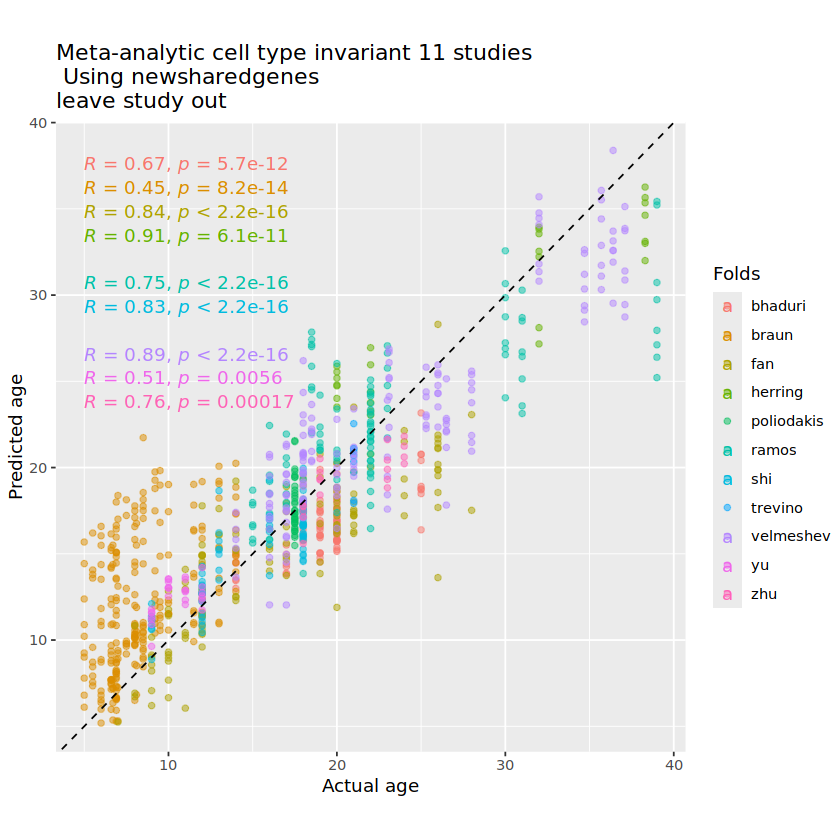

In [21]:
#VISUALIZE MODEL PERFORMANCE ON TRAINING DATA- IN CROSS VALIDATION
performance_celltypeinv_newgenes<-lm_fit_celltypeinvariant_study_newgenes$pred%>%dplyr::filter(alpha==lm_fit_celltypeinvariant_study_newgenes$bestTune$alpha,
                                                                                  lambda==lm_fit_celltypeinvariant_study_newgenes$bestTune$lambda)

performance_celltypeinv_newgenes$study_leftout<-lapply(names(cv_indices_study),function(i){rep(i,length(cv_indices_study[[i]]))})%>%unlist()
                                                          
#
ggplot(data=performance_celltypeinv_newgenes,aes(x=obs,y=pred,col=study_leftout))+geom_point(alpha=0.5)+xlab("Actual age")+ylab("Predicted age")+
labs(color="Folds")+geom_abline(slope=1,linetype=2)+
ggtitle("Meta-analytic cell type invariant 11 studies\n Using newsharedgenes\nleave study out")+stat_cor()+theme(aspect.ratio=1)


In [22]:
coef_new_model<-as.data.frame(coef(lm_fit_celltypeinvariant_study_newgenes$finalModel, lm_fit_celltypeinvariant_study_newgenes$finalModel$lambdaOpt))%>%dplyr::filter(s1!=0)
coef_new_model$genes<-rownames(coef_new_model) #uses 453 genes instead of the previous 462
coef_new_model

,s1,genes
,<dbl>,<chr>
(Intercept),11.571387678,(Intercept)
PDK4,0.424498877,PDK4
TAC1,-0.034367516,TAC1
CX3CL1,2.067834079,CX3CL1
PNPLA4,-0.853965502,PNPLA4
CACNA2D2,-1.768448056,CACNA2D2
CAMK1G,0.702717753,CAMK1G
NFIX,0.171396438,NFIX
CD9,0.059928164,CD9


In [23]:
length(intersect(coefs$genes,coef_new_model$genes))# The new model overlaps with the old model but is also substantially different
setdiff(coef_new_model$genes,coefs$genes)

[1] 418

[1] "GLT8D1"   "ASTE1"    "POLR3E"   "ISOC1"    "IARS2"    "RGS11"   
 [7] "UBE2A"    "DDHD2"    "USP40"    "IKZF5"    "EFHC1"    "TSPO"    
[13] "VCPKMT"   "AHSA1"    "UGGT2"    "SPAG1"    "ZBTB16"   "NKTR"    
[19] "ACTR1B"   "PDE1A"    "LIAS"     "ACTR2"    "ZNF365"   "ZNF473"  
[25] "GALM"     "FBXO25"   "TEX12"    "VIPAS39"  "PRDM8"    "TTC39B"  
[31] "CYB561A3" "EFHB"     "PRRT3"    "ZNF581"   "ZNF274"   "EPHX4"   
[37] "ADCY6"    "TMEM64"   "C12orf60" "BEGAIN"   "NR2F2"    "ZNF696"  
[43] "INCA1"    "SVIP"     "CRYGS"    "ANG"      "WFIKKN1"  "NUPR1"

---

## Predict age in new datasets

### 1. Wang2024 predictions

In [24]:
predictedages_wang<-predict(lm_fit_celltypeinvariant_study_newgenes,t(pb_Wang2024_predict[newsharedgenes,]))

pb_Wang2024_metadata$pbname<-paste0(pb_Wang2024_metadata$Sample_ID,"_",pb_Wang2024_metadata$cell_type)
pb_Wang2024_metadata$predictedage<-predictedages_wang[match(pb_Wang2024_metadata$pbname,colnames(pb_Wang2024_predict))]

#ggplot(data=subset(pb_Wang2024_metadata,pb_Wang2024_metadata$Estimated_postconceptional_age_in_days<280),aes(x=Estimated_postconceptional_age_in_days/7,y=predictedage))+geom_point(aes(col=Class))+
#geom_abline(slope=1,linetype=3)+stat_cor()+ggtitle("Wang_2024_fetalbrainage_newmodel")+xlab("actual age (weeks)")


### 2a. Cao 2020 predictions- telencephalon

In [25]:

predictedages_Cao<-predict(lm_fit_celltypeinvariant_study_newgenes,t(pb_Cao2020_predict[newsharedgenes,]))

pb_Cao2020_metadata$sampleid<-paste0(pb_Cao2020_metadata$donor_id,"_",pb_Cao2020_metadata$cell_type)
pb_Cao2020_metadata$actualage<-pb_Cao2020_metadata$Development_day/7
pb_Cao2020_metadata$predictedage<-predictedages_Cao[match(pb_Cao2020_metadata$sampleid,colnames(pb_Cao2020_predict))]

#ggplot(pb_Cao2020_metadata,aes(x=actualage,y=predictedage))+geom_point(aes(col=cell_type))+stat_cor()+
#  geom_abline(slope=1,linetype=3)+xlim(c(5,30))+ylim(c(5,30))+facet_wrap(~cell_type)+ggtitle("Cao_2020_fetaltelencephalon_newmodel") #all genes are present, so we get perfect performance


### 2b. Cao 2020 predictions- cerebellum

In [26]:
predictedages_Caocerebellum<-predict(lm_fit_celltypeinvariant_study_newgenes,t(pb_Cao2020_cerebellum_predict[newsharedgenes,]))

pb_Cao2020_cerebellum_metadata$sampleid<-paste0(pb_Cao2020_cerebellum_metadata$donor_id,"_",pb_Cao2020_cerebellum_metadata$cell_type)
pb_Cao2020_cerebellum_metadata$actualage<-pb_Cao2020_cerebellum_metadata$Development_day/7
pb_Cao2020_cerebellum_metadata$predictedage<-predictedages_Caocerebellum[match(pb_Cao2020_cerebellum_metadata$sampleid,colnames(pb_Cao2020_cerebellum_predict))]

#ggplot(pb_Cao2020_cerebellum_metadata,aes(x=actualage,y=predictedage))+geom_point(aes(col=cell_type))+stat_cor()+
#  geom_abline(slope=1,linetype=3)+  xlim(c(5,30))+ylim(c(5,30))+facet_wrap(~cell_type)+ggtitle("Cao 2020 cerebellum")

### 3. Walchii 2024 fetal brain vasculature predictions

In [27]:
predictedages_fetalvasc<-predict(lm_fit_celltypeinvariant_study_newgenes,t(pb_vasc_unsorted_predict[newsharedgenes,]))

vasc_unsorted_metadata$actualage<-parse_number(as.character(vasc_unsorted_metadata$age))
vasc_unsorted_metadata$sampleid<-paste0(vasc_unsorted_metadata$Patient,"_",vasc_unsorted_metadata$Cellclusters)
vasc_unsorted_metadata$predictedage<-predictedages_fetalvasc[match(vasc_unsorted_metadata$sampleid,colnames(pb_vasc_unsorted_predict))]

#ggplot(vasc_unsorted_metadata,aes(x=actualage,y=predictedage))+geom_point(aes(col=Cellclusters))+stat_cor()+geom_abline(slope=1,linetype=3)+
#facet_wrap(~Cellclusters)

## <b> Combine and plot all predictions in new datasets

In [28]:
### Combine all meta-analytic predictions
combinedmetadata<-rbind(pb_Wang2024_metadata%>%mutate(actualage=Estimated_postconceptional_age_in_days/7)%>%dplyr::select(predictedage,actualage)%>%dplyr::filter(actualage<40)%>%
                        mutate(dataset="Wang2024_cortex"),
                       pb_Cao2020_metadata%>%dplyr::select(predictedage,actualage)%>%mutate(dataset="Cao2020_telencephalon"),
                       pb_Cao2020_cerebellum_metadata%>%dplyr::select(predictedage,actualage)%>%mutate(dataset="Cao2020_cerebellum"),
                       vasc_unsorted_metadata%>%dplyr::select(predictedage,actualage)%>%mutate(dataset="Walchi2024_fetalbrainvasculature"))


Adding missing grouping variables: `Sample_ID`, `cell_type`


In [29]:
combinedmetadata<-combinedmetadata %>%
  mutate(agegroup = dplyr::case_when(
    actualage < 12 ~ "first trimester",
    actualage >= 12 & actualage < 24 ~ "second trimester",
    actualage >= 24 & actualage < 36 ~ "third trimester",
    TRUE ~ "postnatal"
  ))

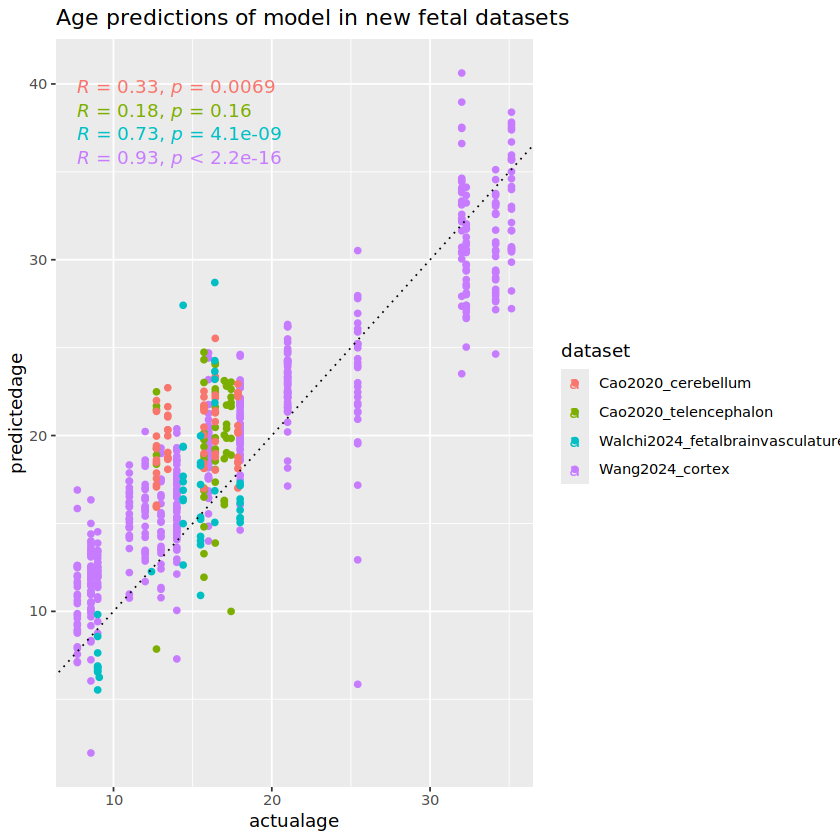

In [30]:
ggplot(combinedmetadata,aes(x=actualage,y=predictedage,col=dataset))+geom_point()+stat_cor()+geom_abline(slope=1,linetype=3)+ggtitle("Age predictions of model in new fetal datasets")


Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_density()`).”


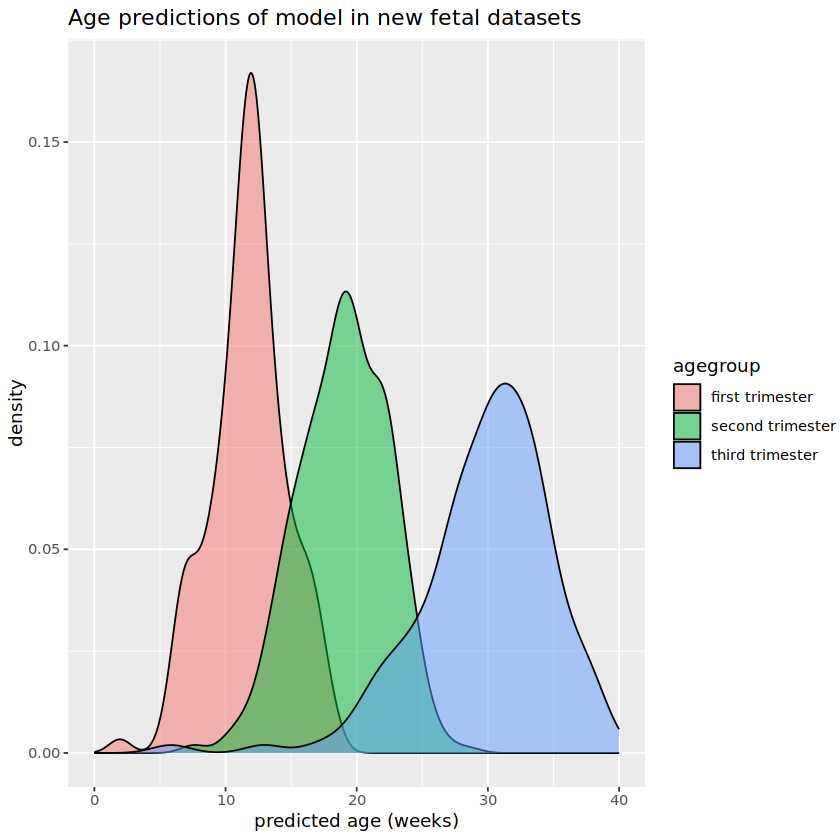

In [31]:
ggplot(data=combinedmetadata,aes(x=predictedage))+geom_density(aes(fill=agegroup),alpha=0.5)+xlim(c(0,40))+
ggtitle("Age predictions of model in new fetal datasets")+
xlab("predicted age (weeks)")


### Predicted ages strongly correlate with actual ages in all new datasets
> <b> Follow a similar process to restrict genes and predict in your new dataset

---